<h1>SASSIE Shipboard Underway CTD Data Use and Visualization</h1>
<p> Shipboard Underway CTD data was collected when the ship was making it's way through open water or areas of low ice, except towards the end of the campaign, when it was used in icier areas. Underway CTD data are downloaded and plotted using the code below! <b>Please run the 'Data Download and Metadata Viewing' and 'Supporting Code' sections in order before running the 'Figure Making Code'.</b> </p>
    
<p>The aim of this notebook is to assist the end user in exploratory data analysis by downloading the SASSIE data from NASA's PODAAC, opening the dataset and displaying it's associated metadata, and creating a few visualizations. This notebook was created by Elizabeth Westbrook. For questions and trouble shooting, please email westbrooke@uncw.edu.</p>

# Data Download and Metadata Viewing

The code in this section will download the dataset from PO.DAAC and open it as an xarray object for metadata and variable attribute viewing.

In [1]:
import numpy as np
import xarray as xr
import glob 
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt
import cartopy
import matplotlib
import os
import sys
import pandas as pd
import requests

<h2>Download The Underway CTD data from PO.DAAC</h2>
<p> All data from the SASSIE campaign is stored on NASA's PO.DAAC. The code in this section of the notebook will download SASSIE Underway CTD data from PO.DAAC, which is accessed through earthdata. If you do not already have an earthdata account, you can create one <a href="https://urs.earthdata.nasa.gov/">here</a> . </p>
    <p>Please enter your earthdata credentials below.</p>

In [2]:
username = 'your_username'
password = 'your_password'
earthdata = requests.auth.HTTPBasicAuth(username, password)

##LOCAL DIRECTORY TO SAVE UNDERWAY CTD DATA
dir_in = 'Data/underway_CTD/' 

The next block of code creates the directory specified above and downloads the shipboard uCTD file to your binder session if it has not already been downloaded.<b> To download the dataset to your local disk from here, right click on the file you want to download and click 'download'. </b>

In [3]:
#if the file has not already been downloaded, it is downloaded here: 
if not os.path.isfile(dir_in+'SASSIE_Fall_2022_shipboard_underwayCTD.nc'):
    os.makedirs(dir_in)
    url = 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SASSIE_L2_SHIPBOARD_UCTD_V1/SASSIE_Fall_2022_shipboard_underwayCTD.nc'
    with requests.Session() as session:
            session.auth = (username, password)
            r1 = session.request('get', url)
            r = session.get(r1.url, auth=(username, password))
            if r.status_code == 200:
                if r.ok:
                    with open(dir_in+'SASSIE_Fall_2022_shipboard_underwayCTD.nc', 'wb') as f:
                        f.write(r.content) 
                        print('Saving Input File: ' + dir_in+'SASSIE_Fall_2022_shipboard_underwayCTD.nc') 
            else:
                print("Error:", r.status_code)
                if r.status_code == 401:
                    print ('Your Username and/or password are incorrect. Please try again')
else: 
    print('Shipboard Underway CTD file is already in binder directory')

Shipboard Underway CTD file is already in binder directory


<h2> View The Metadata Inside the Underway CTD File</h2>

The netCDF file has global metadata attributes and attributes associated with each variable. This next block will load data and metadata of the netCDF file into an xarray object (ds). <br> The data set will then be displayed in a clickable HTML format. 

In [4]:
#See information about the entire dataset
file = dir_in + 'SASSIE_Fall_2022_shipboard_underwayCTD.nc'
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:      (time: 2246, pressure: 1991)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-09T03:55:01.326913280 ... 2022...
  * pressure     (pressure) float64 1.0 1.1 1.2 1.3 ... 199.7 199.8 199.9 200.0
    latitude     (time) float64 ...
    longitude    (time) float64 ...
Data variables:
    temperature  (time, pressure) float64 ...
    salinity     (time, pressure) float64 ...
Attributes: (12/54)
    DOI:                           10.5067/SASSIE-UCTD2
    title:                         SASSIE Arctic Field Campaign Shipboard Und...
    summary:                       Shipboard Underway CTD (uCTD) data collect...
    keywords:                      EARTH SCIENCE > OCEANS > OCEAN TEMPERATURE...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    conventions:                   CF-1.8, ACDD-1.3
    ...                            ...
    time_coverage_end:             2022-09-29T12:14:05Z
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  down
    date_created:                  2023-02-21T15:27:22Z
    date_modified:                 2023-02-21T15:27:22Z
    time_coverage_duration:        P19DT08H19M04S

# Supporting Code 
The code in this section provides a set up for the figure making code below by defining directories for data and figures and creating functions that will be called to actually map the data

<h3>Create a Directory to Save Figures</h3>

In [5]:
#LOCAL DIRECTORY TO SAVE FIGURES
fig_dir ='Figures/underway_CTD/'
#FIGURE DIR 
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

<h3>Define a Colormap and Label for Each Variable in the File</h3>

Within SASSIE's collection of jupyter notebooks, the colormaps used for each variable are held as consistant as possible across all datasets. This function defines the colormap and a label for the variable of interest. 

In [6]:
#DEFINES COLORMAPS AND LABELS OF EACH VARIABLE IN THIS DATA SET
def define_variable_attributes(var):
    if var =='salinity':
        colormap = 'viridis'
        var_label = 'Salinity'
    if var =='temperature':
        colormap = 'plasma'
        var_label = 'Water Temperature ($^{\circ}$C)'
    if var == 'pressure':
        colormap = 'jet'
        var_label = 'Pressure (dbar)'
    if var == 'latitude':
        colormap = 'jet'
        var_label = 'Latitude ($^{\circ}$N)'
    if var == 'longitude':
        colormap = 'jet'
        var_label = 'Longitude ($^{\circ}$E)'
    if var == 'time':
        colormap = 'jet'
        var_label = 'Date'
    return colormap,var_label

<h3>Are you exploring this entire data set, or just the data collected durring a specific time period?</h3>

<p> In order to efficiently accomplish the data collection goals of the SASSIE campaign, the cruise was broken up into five destinct plays. 
    <br>
    <br>Play 1 - Ice and Open Water Survey
    <br>Play 2 - Zig-Zag Open Water Survey 
    <br>Play 3 - Ice Survey
    <br>Play 4 - Drifter-Following Survey Boxes
    <br>Play 5 - Repeated Ice to Open Water Transect</p>
    <p>The following block of code identifies the start and end datetimes of each of these plays and puts the start dates and end dates into lists for easier acess later. </p>

In [7]:
##Identify the start and end times of each play
play1_start = datetime(2022,9,8,8) 
play1_end = datetime(2022,9,13)
play2_start = datetime(2022,9,14)
play2_end = datetime(2022,9,16)
play3_start = datetime(2022,9,16)
play3_end = datetime(2022,9,18)
play4_start = datetime(2022,9,19)
play4_end  = datetime(2022,9,23)
play5_start = datetime(2022,9,25)
play5_end = datetime(2022,9,29)


#Create lists of start dates and end dates
play_start_dates = [play1_start,play2_start,play3_start,play4_start,play5_start,play1_start]
play_end_dates = [play1_end,play2_end,play3_end,play4_end,play5_end,play5_end]


<h3>Define a Function to Create a Map of the Study Area</h3>

The following function creates a map of the SASSIE study area, which is defined by minimum and maximum lat/lon values. These ranges can be changed later when the function is called to zoom in/out on the study area.

In [8]:
def map_study_area(latmin = 70, latmax =74,lonmin=-157,lonmax=-140):
    
    global fig 
    global ax
    
    #create the map as a figure, set the lat and lon ranges, and add land + river data:
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=-150))
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=cartopy.crs.PlateCarree())
    ax.coastlines(color='k')  
    ax.add_feature(cartopy.feature.LAND, facecolor = '0.50',zorder=1)
    ax.add_feature(cartopy.feature.RIVERS,facecolor='blue')
    #Add lat and lon gridlines and labels:
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3) #draw_labels=True gives lat labels.
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(60,75,1))
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-170,-140,2))
    gl.top_labels = False
    gl.bottom_labels = True 
    gl.right_labels = False
    
    #Add markers for reference cities on the coast:
    if (latmin<71.2906) & (lonmin<-156.7886):
        utqiagvik = ax.scatter(-156.7886,71.2906,s=100,transform=cartopy.crs.PlateCarree(),c='red',marker = '*',label='Utqiagvik, AK',zorder=2)
    if (latmin<70.2002) & (lonmax>-148.4597):
        deadhorse = ax.scatter(-148.4597,70.2002,s=100,c='cyan',transform=cartopy.crs.PlateCarree(),marker = '*',label='Deadhorse, AK',zorder=2)
        

<h3>Define a Function to Create a 3D Grid of Latitude, Longitude, and Depth</h3>

The following function creates a 3D grid for plotting 3 dimensional cast data from the castaway CTD. 

In [9]:
def make_3d_grid(latmin,latmax,lonmin,lonmax,dmin,dmax):    
        global fig 
        global ax
        
        fig = plt.figure(figsize=(10,8))
        ax = plt.axes(projection='3d',computed_zorder=False)
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False    


        ax.set_xlim(lonmin, lonmax); ax.set_ylim(latmin,latmax); ax.set_zlim(dmin,dmax);
        ax.get_xaxis().get_major_formatter().set_useOffset(False)
        xticks = list(np.linspace(lonmin,lonmax,4))
        ax.set_xticks(np.around(xticks,2))
        ax.set_xticklabels(np.around(xticks,2),rotation=30, ha='center',va='center', minor=False,size='small')

        yticks = list(np.linspace(latmin,latmax,4))
        ax.set_yticks(np.around(yticks,2))
        ax.invert_yaxis()
        ax.set_yticklabels(np.around(yticks,2),rotation=-15,va='bottom', minor=False,size='small')

        zticks = list(np.linspace(dmin,dmax,4))
        ax.set_zticks(np.around(zticks,2))
        ax.set_zticklabels(np.around(zticks,2),ha='center',va='center', minor=False,size='small')

        ax.set_xlabel('Longitude',fontsize=13,labelpad=10,fontweight='bold')
        ax.set_ylabel('Latitude',fontsize=13,labelpad = 7,fontweight='bold')
        ax.set_zlabel('Depth (m)',fontsize=13,labelpad = 16,fontweight='bold')
        ax.view_init(195,280)
        fig.canvas.draw()
        plt.tight_layout()

<h3>Configure Supporting Data to Add to Maps</h3>

<p>The functions for viewing and plotting this data set below have options to include bathymetr and/or shiptrack data to add context to maps. If you are using these options, run
    <br>the following code blocks to:
    <br>1. Create a directory for SASSIE Ship Track data and acess bathymetry data from NOAA
    <br>2. Define functions that add these data to your map when called.</p>

<h4>Create Directory for Shiptrack Data and Access Bathymetry Data </h4>

In [10]:
## DIRECTORY TO SHIP TRACK DATA
ship_dir =  'Data/TSG/' 

#DOWLOAD SHIPTRACK DATA
if not os.path.isfile(ship_dir+'SASSIE_Fall_2022_Shipboard_TSG.nc'):
    os.makedirs(ship_dir)
    url = 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SASSIE_L2_SHIPBOARD_TSG_V1/SASSIE_Fall_2022_Shipboard_TSG.nc'
    with requests.Session() as session:
            session.auth = (username, password)
            r1 = session.request('get', url)
            r = session.get(r1.url, auth=(username, password))
            if r.status_code == 200:
                if r.ok:
                    with open(ship_dir+'SASSIE_Fall_2022_Shipboard_TSG.nc', 'wb') as f:
                        f.write(r.content) 
                        print('Saving Input File: ' + ship_dir+'SASSIE_Fall_2022_Shipboard_TSG.nc') 
            else:
                print("Error:", r.status_code)
                if r.status_code == 401:
                    print ('Your Username and/or password are incorrect. Please try again')
else: 
    print('Shipboard TSG file is already in local directory')
    
    
#READ IN TOPOGRAPHY/BATHYMETRY DATA
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo2.nc'
etopodata = xr.open_dataset(url) 

Shipboard TSG file is already in local directory


<h4>Define a Function to Index Relevant Bathymetry Data and Add it to the Map</h4>
This function will index bathymetry data from NOAA within the appropriate spatial range and add it to the map. 


In [11]:
def add_bathy_data(latmin,latmax,lonmin,lonmax):
        topoin = etopodata.rose.values[0:-1:5,1:-1:5]
        lons = etopodata.etopo2_x.values[0:-1:5]
        lats = etopodata.etopo2_y.values[0:-1:5]
        lons_in_range = lons[np.where((lons >lonmin-1) & (lons<lonmax+1))]
        lats_in_range = lats[np.where((lats >latmin-1) & (lats<latmax+1))]
        topo_in_range = np.squeeze(topoin[np.squeeze(np.where((lats >latmin-1) & (lats<latmax+1))),:][:,np.where((lons >lonmin-1) & (lons<lonmax+1))])
        [bathy_lon,bathy_lat] = np.meshgrid(lons_in_range,lats_in_range)
        
        bathy = ax.contour(bathy_lon,bathy_lat,topo_in_range,np.arange(-6000,-1000,300),transform=cartopy.crs.PlateCarree(),cmap='gray',alpha = 0.2,zorder = 0)

<h4>Define a Function to Add Shiptrack Data to a Map</h4>
This function will pull the lat/lon data from the SASSIE Shipboard TSG file and put it onto a map o a 3D grid. 

In [12]:
def add_ship_track(mode,start_date,end_date):
        ds_ship = xr.open_dataset(ship_dir+'SASSIE_Fall_2022_Shipboard_TSG.nc')
        if mode == 'grid':
            ds_ship = ds_ship.sel(time=slice(start_date,end_date))
        ship_time = np.squeeze(ds_ship['time'])
        ship_lat = np.squeeze(ds_ship['latitude'])
        ship_lon = np.squeeze(ds_ship['longitude'])
        if mode =='map':
            track = ax.plot(ship_lon, 
                         ship_lat,linewidth = 0.5,
                         c='black',
                           transform=cartopy.crs.PlateCarree(),label = 'Ship Track',zorder=1)
        if mode == 'grid':
            track = ax.plot(ship_lon, 
                         ship_lat,
                         c='black',label = 'Ship Track',zorder=2)

# Figure Making Code 

<h2> Mapping the Time and Location of Underway CTD Data Collection</h2>

The map_uCTD_deployments function shows the locations of Underway CTD deployments throughout the campaign on a map, colored by time. Various features of this function: 
    <br>2. This function adds bathymetry contours showing the position of the continental shelf by default for reference. 

In [13]:
#PLOT THE LOCATION OF THE UNDERWAY CTD CASTS ON THE SHIP TRACK 
def map_uCTD_deployments(ship_track=True, bathymetry_data=True):
 
    #LOAD CASTAWAY CTD DATA
    CTD_time = np.squeeze(ds['time'])
    CTD_lat = np.squeeze(ds['latitude'])
    CTD_lon = np.squeeze(ds['longitude'])
    
    #Define the boundaries of the map:
    latmin = 70
    latmax =74
    lonmin=-157
    lonmax=-144
    
    #create the map:
    map_study_area(latmin=latmin,latmax=latmax,lonmin=lonmin,lonmax=lonmax)
    
    #Add a title: 
    ax.set_title('Underway CTD Deployment Locations',fontsize=22,pad=1) 
    
    #add optional map add-ons:
    if bathymetry_data == True: 
        add_bathy_data(latmin,latmax,lonmin,lonmax)   
    if ship_track == True:
        add_ship_track('map',play1_start,play5_end)
     
    #APPLY CTD TIME AND LOCATION DATA
    casts = ax.scatter(CTD_lon,CTD_lat,s = 10,
                       c = CTD_time,cmap = 'jet',
                       transform=cartopy.crs.PlateCarree(),zorder=2,
                      vmin=min(CTD_time.values), vmax=max(CTD_time.values))
    #Add a color bar:
    cbar = fig.colorbar(casts, ax=ax, orientation="horizontal", pad=0.1)
    cbar.set_label(label='Date',size='large',weight='bold')
    cbar_tick_array=(np.linspace(ds['time'].values[0].astype('int64'),ds['time'].values[-1].astype('int64'),5))
    cbar.set_ticks(cbar_tick_array)
    cbar.set_ticklabels(pd.to_datetime(cbar_tick_array).date)
    
    #Add a legend:
    plt.legend(loc=2)

    ##SAVE FIGURE 
    if not os.path.exists(fig_dir+'deployment_map/'):
        os.makedirs(fig_dir+'deployment_map/')
    
    print('Saving Output Image:  '+fig_dir+'deployment_map/CTD_deployment_map.png')
    plt.savefig(fig_dir+'deployment_map/CTD_deployment_map.png',dpi='figure',format='png',bbox_inches='tight')
    

Saving Output Image:  Figures/underway_CTD/deployment_map/CTD_deployment_map.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


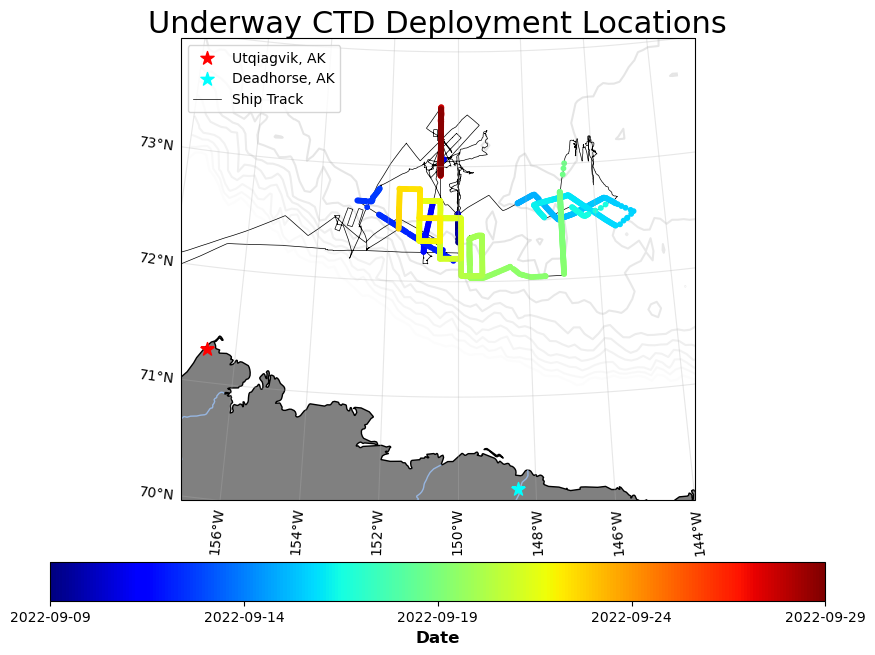

In [14]:
map_uCTD_deployments()

<h3>Three Dimensional Representation of Vertical Profile Data</h3>
Use the code in this section to plot the Underway CTD profile locations and depths on a 3D grid, colored by a physical measurement variable from the file (temperature, salinity, density, etc.)

In [15]:
##USE TO PLOT THE PROFILES TAKEN WITHIN A DATE RANGE 
def uCTD_profiles(start_date,end_date,var,ship_track=True):
    try:
        #LOAD Underway CTD DATA
        selected_casts = ds.sel(time=slice(start_date,end_date))
        CTD_lat = selected_casts['latitude']
        CTD_lon = selected_casts['longitude']
        CTD_depth = selected_casts['pressure']
        CTD_var = selected_casts[var]

        #put lat, lon, and depth in 2D format:
        [depth,lat] = np.meshgrid(CTD_depth,CTD_lat)
        [depth,lon] = np.meshgrid(CTD_depth,CTD_lon)

        #define colormap and label for variable of choice:
        colormap,var_label = define_variable_attributes(var)

        #define latitude and longitude ranges for the 3D grid. 
        latmin = min(CTD_lat.values)
        latmax = max(CTD_lat.values)
        lonmin = min(CTD_lon.values)
        lonmax = max(CTD_lon.values)
        pmin = min(CTD_depth.values)
        pmax = max(CTD_depth.values)+0.5

        #make the 3d grid for plotting: 
        make_3d_grid(latmin,latmax,lonmin,lonmax,pmin,pmax)

        #add a title to the grid:
        ax.set_title('Underway CTD'+' '+var_label+' '+'\n Readings from'+' '+str(start_date.year)+'/'+str(start_date.month).zfill(2)+'/'+str(start_date.day).zfill(2)+' '+str(start_date.hour).zfill(2)+':'+str(start_date.minute).zfill(2)+' to '+str(end_date.year)+'/'+str(end_date.month).zfill(2)+'/'+str(end_date.day).zfill(2)+' '+str(end_date.hour).zfill(2)+':'+str(end_date.minute).zfill(2),fontsize=15,y = 0.93)

        #Add the ship track to show the path of the casting:
        if ship_track==True:
            add_ship_track('grid',start_date,end_date)

        ##APPLY CTD DATA   
        a = ax.scatter(lon,lat,depth,c=(CTD_var.values),cmap = colormap,s=2,zorder=1) 
        #add a colorbar 
        fig.colorbar(a,label = var_label, shrink=0.75, pad = 0)

        ## SAVE THE FIGURE
        if not os.path.exists(fig_dir+var+'/'):
            os.makedirs(fig_dir+var+'/')

        print('Saving Output Image:  '+fig_dir+var+'/'+'CTD'+var+str(start_date.year)+str(start_date.month).zfill(2)+str(start_date.day).zfill(2)+str(start_date.hour).zfill(2)+str(start_date.minute).zfill(2)+'_'+str(end_date.year)+str(end_date.month).zfill(2)+str(end_date.day).zfill(2)+str(end_date.hour).zfill(2)+str(end_date.minute).zfill(2)+'.png')
        plt.savefig(fig_dir+var+'/'+'CTD'+var+str(start_date.year)+str(start_date.month).zfill(2)+str(start_date.day).zfill(2)+str(start_date.hour).zfill(2)+str(start_date.minute).zfill(2)+'_'+str(end_date.year)+str(end_date.month).zfill(2)+str(end_date.day).zfill(2)+str(end_date.hour).zfill(2)+str(end_date.minute).zfill(2)+'.png',dpi='figure',format='png',bbox_inches='tight')
    except: 
        print('There are no Castaway CTD profiles from ' + str(start_date.year)+'/'+str(start_date.month).zfill(2)+'/'+str(start_date.day).zfill(2)+' '+str(start_date.hour).zfill(2)+':'+str(start_date.minute).zfill(2)+' to '+str(end_date.year)+'/'+str(end_date.month).zfill(2)+'/'+str(end_date.day).zfill(2)+' '+str(end_date.hour).zfill(2)+':'+str(end_date.minute).zfill(2))
              
              
              

Saving Output Image:  Figures/underway_CTD/temperature/CTDtemperature202209190000_202209230000.png


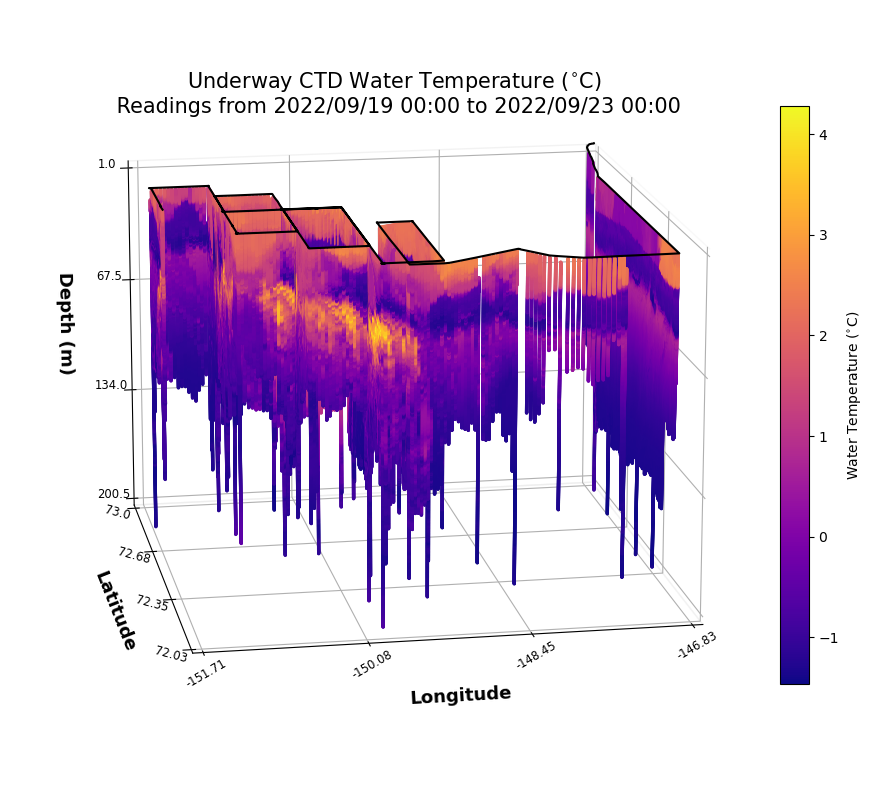

In [16]:
uCTD_profiles(play4_start,play4_end,'temperature')
#uCTD_profiles(play4_start,play4_end,'salinity')

<h2>Two Dimensional Representation of Vertical Profile Data</h2>
Use the code in this section to plot the Underway CTD profiles on a 2D time-depth axis, colored by a physical measurement variable from the file (temperature, salinity)

In [17]:
##MAKES A 2D PLOT OF THE CTD VARIABLES ON TIME-DEPTH AXIS (NO INTERPOLATION OF LAT/LON)
def plot_uCTD_2D(start_time,end_time,var,var_min,var_max):
    try:
        #Cut the CTD data set down to the specified time range:
        ds_limited = ds.sel(time=slice(start_time,end_time))

        #load the CTD data within this time range
        CTD_time = ds_limited['time'].values
        CTD_depth = ds_limited['pressure'].values
        CTD_var = ds_limited[var].values

        #put time and depth into a 2D format
        [depth,time] = np.meshgrid(CTD_depth,CTD_time)

        ##SET UP THE 2D PLOT 
        colormap,var_label = define_variable_attributes(var)

        dmin = min(CTD_depth)
        dmax = max(CTD_depth)
        tmin = min(CTD_time)
        tmax = max(CTD_time)

        fig = plt.figure(figsize=(10,4))

        plt.title('Castaway CTD'+' '+var_label+' '+'Readings \nfrom '+str(start_time.year)+'/'+str(start_time.month).zfill(2)+'/'+str(start_time.day).zfill(2)+' to '+str(end_time.year)+'/'+str(end_time.month).zfill(2)+'/'+str(end_time.day).zfill(2),fontsize=15,pad=None)

        plt.xlim(tmin, tmax); plt.ylim(dmin,100);
        total_timedelta = tmax-tmin
        third_of_timedelta = total_timedelta/3
        plt.xticks([tmin,tmin+third_of_timedelta, tmin+ 2*third_of_timedelta, tmax])
        ytick = list(np.arange(0,100,15))
        plt.yticks(np.around(ytick,2))
        plt.xlabel('Date',fontsize=16)
        plt.ylabel('Depth(m)',fontsize=16)
        plt.gca().invert_yaxis()

        ##APPLY THE CTD DATA
        ax = plt.scatter(time,depth,s=1,c=CTD_var,cmap=colormap,vmin = var_min,vmax=var_max)

        #add a colorbar
        fig.colorbar(ax).set_label(label = var_label,size=15,weight='bold')

        ##SAVE THE FIGURE:
        if not os.path.exists(fig_dir+var+'/2d/'):
            os.makedirs(fig_dir+var+'/2d/')

        print('Saving Output Image:  '+fig_dir+var+'/2d/'+'CTD_'+var+'_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+str(start_time.hour).zfill(2)+str(start_time.minute).zfill(2)+'_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+str(end_time.hour).zfill(2)+str(end_time.minute).zfill(2)+'.png')
        plt.savefig(fig_dir+var+'/2d/'+'CTD_'+var+'_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+str(start_time.hour).zfill(2)+str(start_time.minute).zfill(2)+'_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+str(end_time.hour).zfill(2)+str(end_time.minute).zfill(2)+'.png',dpi='figure',format='png',bbox_inches='tight')
    except: 
        print('There are no Castaway CTD profiles from ' + str(start_date.year)+'/'+str(start_date.month).zfill(2)+'/'+str(start_date.day).zfill(2)+' '+str(start_date.hour).zfill(2)+':'+str(start_date.minute).zfill(2)+' to '+str(end_date.year)+'/'+str(end_date.month).zfill(2)+'/'+str(end_date.day).zfill(2)+' '+str(end_date.hour).zfill(2)+':'+str(end_date.minute).zfill(2))
       

Saving Output Image:  Figures/underway_CTD/temperature/2d/CTD_temperature_202209080800_202209290000.png
Saving Output Image:  Figures/underway_CTD/salinity/2d/CTD_salinity_202209080800_202209290000.png


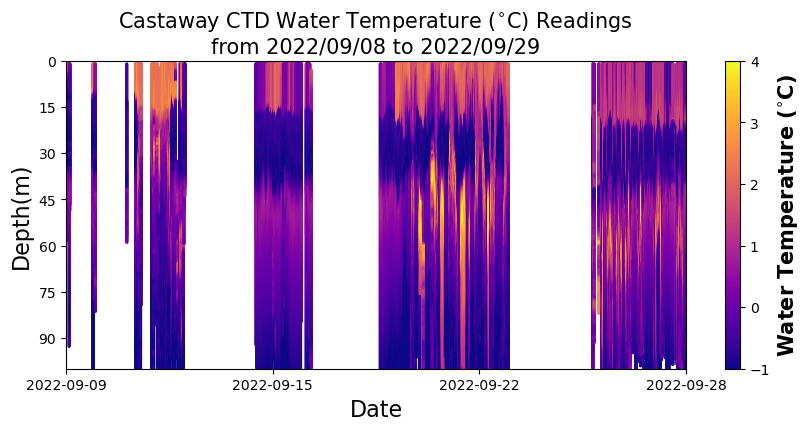

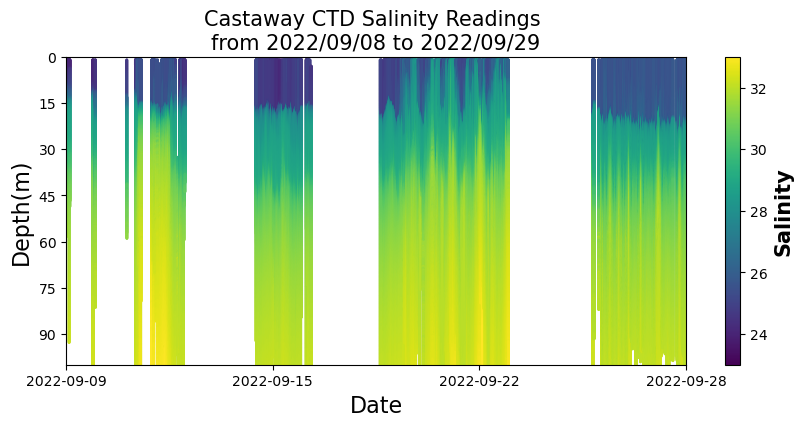

In [18]:
plot_uCTD_2D(play1_start,play5_end,'temperature',-1,4)
plot_uCTD_2D(play1_start,play5_end,'salinity',23,33)


<h2>Plots of Individual Casts by Cast Number</h2>
use this code to make polts of individual underway CTD casts. The temperature and salinity profiles can be plotted on 2 seperate subplots using 'plot_CTD_cast_profile_subplots' or temperature and salnity can be put on the same set of axis with 'plot_uCTD_cast_profile_sameplot'

In [19]:
##USE TO PLOT AN INDIVIDUAL CAST BY CAST NUMBER (SEPERATE AXIS)
def plot_CTD_cast_profile_subplots(cast_number):
    
    #LOAD CTD DATA 
    CTD_sal = np.squeeze(ds['salinity'].values[cast_number,:])
    CTD_temp = np.squeeze(ds['temperature'].values[cast_number,:])
    CTD_depth = np.squeeze(ds['pressure'].values)
    CTD_time = np.squeeze(ds['time'].values[cast_number]).astype('int64')
    
    ## PLOT THE DATA
    fig,axs = plt.subplots(1,2,sharey=True)
    axs[0].plot(CTD_temp,CTD_depth,linewidth=0.4,c='black')
    axs[0].invert_yaxis()
    #axs[0].set_title('Water Temperature ($^{\circ}$C)')
    axs[0].set_xlabel('Temperature ($^{\circ}$C)')
    axs[0].set_ylabel('Depth (m)')
    axs[1].plot(CTD_sal,CTD_depth,linewidth=0.4,c='black')
    #axs[1].set_title('Salinity')
    axs[1].set_xlabel('Salinity')
    
    fig.suptitle('uCTD Profiles from Cast '+str(cast_number)+' on '+str(pd.to_datetime(CTD_time).year).zfill(2)+'/'+str(pd.to_datetime(CTD_time).month).zfill(2)+'/'+str(pd.to_datetime(CTD_time).day).zfill(2)+' at '+str(pd.to_datetime(CTD_time).hour).zfill(2)+':'+str(pd.to_datetime(CTD_time).minute).zfill(2)+':'+str(pd.to_datetime(CTD_time).second).zfill(2))
    
    ## SAVE THE FIGURE
    if not os.path.exists(fig_dir+'profiles/'):
        os.makedirs(fig_dir+'profiles/')
    print('Saving Output Image:  '+fig_dir+'profiles/'+'uCTD_profile'+str(cast_number)+'_'+str(pd.to_datetime(CTD_time).year)+str(pd.to_datetime(CTD_time).month).zfill(2)+str(pd.to_datetime(CTD_time).day).zfill(2)+str(pd.to_datetime(CTD_time).hour).zfill(2)+str(pd.to_datetime(CTD_time).minute).zfill(2)+str(pd.to_datetime(CTD_time).second).zfill(2)+'.png')
    plt.savefig(fig_dir+'profiles/'+'uCTD_profile'+str(cast_number)+'_'+str(pd.to_datetime(CTD_time).year)+str(pd.to_datetime(CTD_time).month).zfill(2)+str(pd.to_datetime(CTD_time).day).zfill(2)+str(pd.to_datetime(CTD_time).hour).zfill(2)+str(pd.to_datetime(CTD_time).minute).zfill(2)+str(pd.to_datetime(CTD_time).second).zfill(2)+'.png',dpi='figure',format='png',bbox_inches='tight')


Saving Output Image:  Figures/underway_CTD/profiles/uCTD_profile100_20220912040552.png


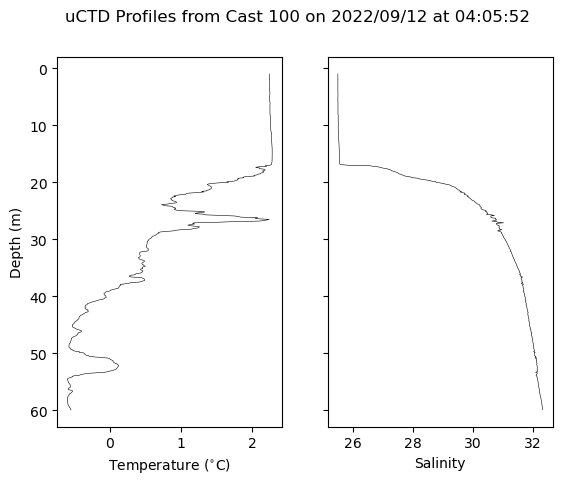

In [20]:
plot_CTD_cast_profile_subplots(100)

In [21]:
##USE TO PLOT AN INDIVIDUAL CAST BY CAST NUMBER (SAME AXIS)
def plot_uCTD_cast_profile_sameplot(cast_number):
    
    #LOAD CTD DATA 
    CTD_sal = np.squeeze(ds['salinity'].values[cast_number,:])
    CTD_temp = np.squeeze(ds['temperature'].values[cast_number,:])
    CTD_depth = np.squeeze(ds['pressure'].values)
    CTD_time = np.squeeze(ds['time'].values[cast_number]).astype('int64')
    CTD_lat = np.squeeze(ds['latitude'].values[cast_number])
    CTD_lon = np.squeeze(ds['longitude'].values[cast_number])
    
    ## PLOT THE DATA
    fig,ax1 = plt.subplots()
    ax2 = ax1.twiny()
    ax1.plot(CTD_temp,CTD_depth,linewidth=0.4,c='blue')
    ax1.set_xlabel('Temperature ($^{\circ}$C)',color = 'blue')
    ax1.set_ylabel('Depth (m)')
    ytick_array = np.arange(0,100,20)
    ax1.set_ylim(0,100)
    ax1.set_yticks(ytick_array)
    ax1.invert_yaxis()
    ax2.plot(CTD_sal,CTD_depth,linewidth=0.4,c='red')
    ax2.set_xlabel('Salinity',color ='red')    
    fig.suptitle('uCTD Profiles from Cast '+str(cast_number)+' at ' +str(np.around(CTD_lat,decimals=2))+'$^{\circ}$N, '+str(np.around(CTD_lon,decimals=2))+'$^{\circ}$E \n on '+str(pd.to_datetime(CTD_time).year).zfill(2)+'/'+str(pd.to_datetime(CTD_time).month).zfill(2)+'/'+str(pd.to_datetime(CTD_time).day).zfill(2)+' at '+str(pd.to_datetime(CTD_time).hour).zfill(2)+':'+str(pd.to_datetime(CTD_time).minute).zfill(2)+':'+str(pd.to_datetime(CTD_time).second).zfill(2),y=1.05)
    
    ## SAVE THE FIGURE
    if not os.path.exists(fig_dir+'profiles/'):
        os.makedirs(fig_dir+'profiles/')
    print('Saving Output Image:  '+fig_dir+'profiles/'+'CTD_profile'+str(cast_number)+'_'+str(pd.to_datetime(CTD_time).year)+str(pd.to_datetime(CTD_time).month).zfill(2)+str(pd.to_datetime(CTD_time).day).zfill(2)+str(pd.to_datetime(CTD_time).hour).zfill(2)+str(pd.to_datetime(CTD_time).minute).zfill(2)+str(pd.to_datetime(CTD_time).second).zfill(2)+'.png')
    plt.savefig(fig_dir+'profiles/'+'CTD_profile'+str(cast_number)+'_'+str(pd.to_datetime(CTD_time).year)+str(pd.to_datetime(CTD_time).month).zfill(2)+str(pd.to_datetime(CTD_time).day).zfill(2)+str(pd.to_datetime(CTD_time).hour).zfill(2)+str(pd.to_datetime(CTD_time).minute).zfill(2)+str(pd.to_datetime(CTD_time).second).zfill(2)+'.png',dpi='figure',format='png',bbox_inches='tight')


Saving Output Image:  Figures/underway_CTD/profiles/CTD_profile100_20220912040552.png


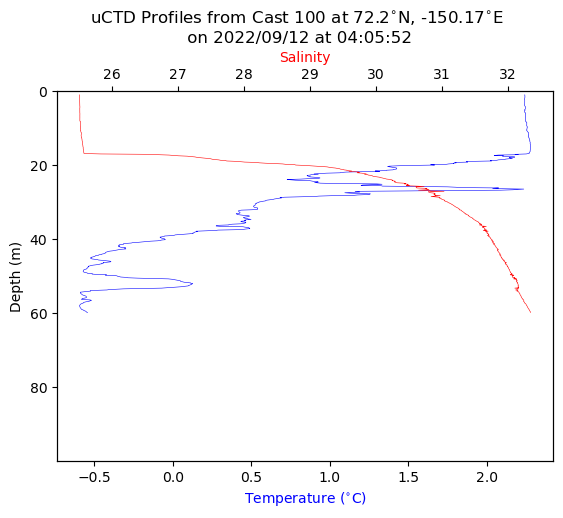

In [22]:
plot_uCTD_cast_profile_sameplot(100)

<h2> T-S Diagram of Underway CTD Data in a Specific Time Range</h2>
Use this code to make temperture-salinity (T-S) diagrams of all of the Underway CTD data within a given time range, colored by a coordinate variable (lat,lon,time, depth)

In [23]:
def plot_T_S_diagram(start_time,end_time,var):
    
    ##PULL OUT THE DATA WITHIN THE START AND END TIME RANGE
    ds_limited = ds.sel(time=slice(start_time,end_time))
    CTD_temp = ds_limited['temperature'].values
    CTD_depth = ds_limited['pressure'].values
    CTD_sal = ds_limited['salinity'].values
    CTD_var = ds_limited[var].values
    CTD_time = ds_limited['time'].values   
    

    if (var =='depth')|(var=='pressure'):
        [var_values,time] = np.meshgrid(CTD_var,CTD_time)
    else:
        [depth,var_values] = np.meshgrid(CTD_depth,CTD_var)

                
    ##SET UP THE 2D PLOT
    colormap,var_label = define_variable_attributes(var)

    fig = plt.figure(figsize=(10,4))
    plt.title('Temperature-Salinity Diagram of Underway CTD Data')
    
    if var=='pressure':
        ax = plt.scatter(CTD_sal,CTD_temp,s=1,c=var_values,cmap=colormap,vmin=0,vmax=100)
    else:
        ax = plt.scatter(CTD_sal,CTD_temp,s=1,c=var_values,cmap=colormap,vmin=CTD_var.min(),vmax=CTD_var.max())
    plt.xlim((24,35))
    plt.xlabel('Salinity',fontsize=16)
    plt.ylabel('Temperature ($^{\circ}$C)',fontsize=16)
    
    ##SET UP COLORBAR
    if (var == 'time'): 
        cbar = fig.colorbar(ax, orientation="vertical", pad=0.1)
        cbar.set_label(label=var_label,size='large',weight='bold')
        cbar_tick_array=(np.linspace(ds[var].values[0].astype('int64'),ds[var].values[-1].astype('int64'),5))
        cbar.set_ticks(cbar_tick_array)
        cbar.set_ticklabels(pd.to_datetime(cbar_tick_array).date)
    else:
        fig.colorbar(ax).set_label(label = var_label,size=15,weight='bold')

    ##SAVE THE FIGURE
    if not os.path.exists(fig_dir+'t_s/'):
        os.makedirs(fig_dir+'t_s/')
    print('Saving Output Image:  '+fig_dir+'t_s/T_S_Diagram_'+var+'.png')
    plt.savefig(fig_dir+'t_s/T_S_Diagram_'+var+'.png',dpi='figure',format='png',bbox_inches='tight')


Saving Output Image:  Figures/underway_CTD/t_s/T_S_Diagram_pressure.png
Saving Output Image:  Figures/underway_CTD/t_s/T_S_Diagram_latitude.png


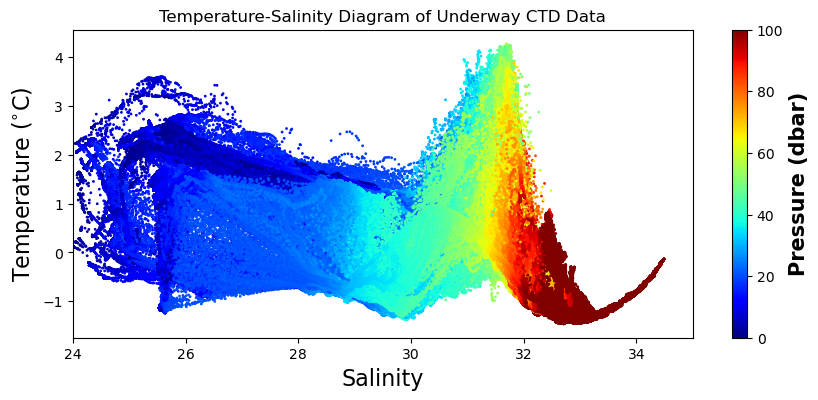

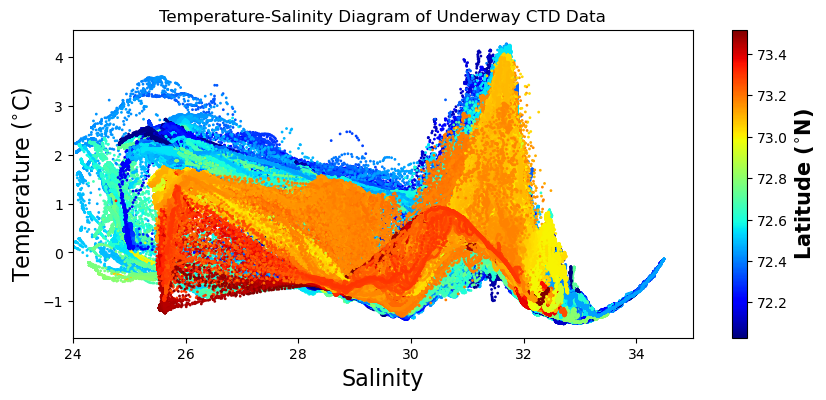

In [24]:
plot_T_S_diagram(play1_start,play5_end,'pressure')
plot_T_S_diagram(play1_start,play5_end,'latitude')